# Build and train PCA tabular data
## Purpose
In this example we will demonstrate how to:

   - Build a Coreset tree for PCA analysis on a dataset.
   - Train a PCA model directly on the Coreset tree using the `fit` method
   - Compare the coreset-based model's quality to a PCA model built on the entire dataset
   - Add additional samples in batches to the Coreset tree using the `partial_build` method, to simulate a production-like use case where more data is accrued over time and added to the model

In this example we'll be using the well-known HIGGS dataset (https://archive.ics.uci.edu/ml/datasets/HIGGS). The first 6 million samples out of the 11 million samples in the dataset will be used for the PCA analysis task, to shorten the running time of the notebook.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from time import time
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from dataheroes import CoresetTreeServicePCA, DataTuningParams
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

Define a cost function for evaluating the dimensionality reduction of the PCA model on the full dataset and on the root Coreset.

In [ ]:
def pca_cost_function(model, matrix):
    """
    Calculates the Frobenius norm of the difference between the input matrix and the
      reconstructed matrix obtained by means of the PCA model
    Parameters:
      model: the PCA model used for matrix reconstruction
    """
    return np.linalg.norm(model.inverse_transform(model.transform(matrix)) - matrix)

Define the number of components to keep when performing the dimensionality reduction.

In [3]:
n_components = 2

## Prepare dataset

Construct a routine for retrieving and preparing the dataset.

In [ ]:
import gdown


def load_higgs_dataset(start_path: str):
    """
    Loads the HIGGS dataset, described at the link below:
      https://archive.ics.uci.edu/ml/datasets/HIGGS
    Parameters:
      start_path : str - indicates the local folder where caching and preprocessed files are to be stored
    Return - dataset's features as numpy array
    """

    # Dataset numpy filepath
    dataset_filepath = start_path / "x.npy"

    if not dataset_filepath.is_file():
        # We already processed the dataset and stored it on google drive so we are going to download it from there because it is faster
        # If you need more details on the original dataset, please check the link above
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1Xvd1zfa9mhv4bu2O9u9v7l5u8aEXAdrZ?usp=drive_link",
            output=start_path.as_posix(),
            quiet=False,
        )

    x = np.load(dataset_filepath)

    return x

In [ ]:
# Prepare the data directory
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)

# Retrieve the dataset
x = load_higgs_dataset(data_dir)

# Only keep the first 6 million samples out of the 11 million samples in the dataset to shorten the running time of the notebook
x = x[:6_000_000, :]

# Standardize by mean and standard deviation the dataset features
x = StandardScaler().fit_transform(x)

Retrieving folder contents


Processing file 1FdzmJd_i0sNd43C_TDPtMr2eGAKX887j x.npy


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1FdzmJd_i0sNd43C_TDPtMr2eGAKX887j
From (redirected): https://drive.google.com/uc?id=1FdzmJd_i0sNd43C_TDPtMr2eGAKX887j&confirm=t&uuid=b7d0c421-8612-4548-9e2f-bb11ec29c3c4
To: /Users/mike/DataHeroes/dh-library/examples/build_and_train/data/x.npy
100%|██████████| 1.85G/1.85G [00:46<00:00, 40.1MB/s]
Download completed


## 1. Build the tree
Run `build` method to build the tree. The dataset instances are added to the Coreset tree iteratively, to simulate a production-like use case where more data is accrued over time and added to the model. In the end, the tree will include 6M samples. At Coreset tree's construction, we split the data instances into chunks in the size of `chunk_size` and create from each one a Coreset. The `coreset_size` argument represents the coreset size of each node in the tree.

In [ ]:
# Initialize the Coreset tree
# The tree uses the local file system to store its data.
# After this step you will have a new directory .dataheroes_cache

coreset_creation_start_time = time()
service_obj = CoresetTreeServicePCA(
    optimized_for="training",
    data_tuning_params=DataTuningParams(coreset_size=[15_000]),
    chunk_size=125_000,
)
coreset_creation_time = time() - coreset_creation_start_time

## 2. Populate the Coreset tree
Add samples to the Coreset tree, in an iterative manner. In each step, 600K samples will be added to the tree.
First, construct a number of variables to be used by the dimensionality reduction task.

In [ ]:
# Define size of dataset slice
x_slice_size = 600_000
# Determine the number of slices
num_slices = (6_000_000 // x_slice_size) - 1
# Construct dataset slices: they will be used by the root Coreset and the full dataset
x_slices = np.split(x, np.cumsum([x_slice_size] * num_slices))
# Construct dataset cumulative slices: they will be used by the full dataset
x_cumulative_slices = [x[0:limit] for limit in np.cumsum([x_slice_size] * (num_slices + 1))]
# Calculate cumulative number of samples analyzed per iteration
num_samples_per_iteration = [len(a) for a in x_cumulative_slices]

In each step, fit a PCA model on the root Coreset of the tree, using the `fit` method and store the time needed for building/updating the coreset plus the time for fitting the PCA model on the root Coreset of the tree, together with any data required in the next analysis steps.

In [ ]:
# Initialize a list of trained PCA models, build plus fit times and the number of samples in the root Coreset
coreset_pca_models = []
coreset_times = []
coreset_root_num_samples = []

for i, x_slice in enumerate(x_slices):
    if i == 0:
        # In the first iteration use tree's build method to build the tree
        coreset_build_start_time = time()
        service_obj.build(x_slice)
        coreset_build_time = time() - coreset_build_start_time
    else:
        # In all but the first iteration use tree's partial_build method to add new samples to the tree
        coreset_build_start_time = time()
        service_obj.partial_build(x_slice)
        coreset_build_time = time() - coreset_build_start_time

    # Fit the internal coreset's PCA model on the root Coreset of the tree
    coreset_fit_start_time = time()
    coreset_model = service_obj.fit(**{"n_components": n_components})
    coreset_fit_time = time() - coreset_fit_start_time

    # Update the PCA models list
    coreset_pca_models.append(coreset_model)
    # Update the times list
    coreset_times.append(coreset_build_time + coreset_fit_time)

    # Obtain the root Coreset of the tree and store the number of samples in it
    coreset_root_num_samples.append(service_obj.get_coreset_size())

2024-06-27 21:26:10 Build Started.
2024-06-27 21:26:10 Completed chunk #1, (chunk was built in 0.019 seconds)
2024-06-27 21:26:11 Completed chunk #2, (chunk was built in 0.038 seconds)
2024-06-27 21:26:11 Completed chunk #3, (chunk was built in 0.015 seconds)
2024-06-27 21:26:11 Completed chunk #4, (chunk was built in 0.026 seconds)
2024-06-27 21:26:13 Build Completed in: 0:00:03.129.
Using WPCA model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMRegressor(**params), **other_params)
2024-06-27 21:26:14 Build Started.
2024-06-27 21:26:14 Completed chunk #5, (chunk was built in 0.018 seconds)
2024-06-27 21:26:14 Completed chunk #6, (chunk was built in 0.022 seconds)
2024-06-27 21:26:15 Completed chunk #7, (chunk was built in 0.018 seconds)
2024-06-27 21:26:16 Completed chunk #8, (chunk was built in 0.022 seconds)
2024-06-27 21:26:17 Completed chunk #9, (chunk was built in 0.018 seconds)
2024-06-27 21:26:18 Build Completed in: 0:00:04.473.
Usin

## 3. Run the PCA analysis on the full dataset
The PCA analysis will be performed iteratively, on the full dataset. Starting with the very first 600K samples, of the first iteration, in each new step, the next 600K samples of the full dataset will be appended. Also, in each step, a PCA model will be fitted on the current iteration's full number of samples and the same key performance indicators will be stored, as for the Coreset tree analysis above.

In [ ]:
# Initialize a list of trained PCA models and fit times for the full dataset
full_dataset_pca_models = []
full_dataset_times = []

for x_cumulative_slice in x_cumulative_slices:
    # Fit a PCA model on the on the cumulative slice of the full dataset
    full_dataset_fit_start_time = time()
    full_dataset_model = PCA(n_components=n_components).fit(x_cumulative_slice)
    full_dataset_fit_time = time() - full_dataset_fit_start_time

    # Update the PCA models list
    full_dataset_pca_models.append(full_dataset_model)
    # Update the times list
    full_dataset_times.append(full_dataset_fit_time)

## 4 Visualize key performance indicators

### 4.1 Visualize coreset tree and full dataset PCA analysis scores

Calculate the score for each model using the defined cost function on the full dataset and the coreset models, for each iteration.

In [10]:
# Initialize lists of scores
coreset_scores = []
full_dataset_scores = []

# Calculate PCA models' scores, in each iteration and append them to their respective list
for i, x_cumulative_slice in enumerate(x_cumulative_slices):
    coreset_scores.append(pca_cost_function(coreset_pca_models[i], x_cumulative_slice))
    full_dataset_scores.append(pca_cost_function(full_dataset_pca_models[i], x_cumulative_slice))

Plot the costs of the two PCA models, for each iteration.

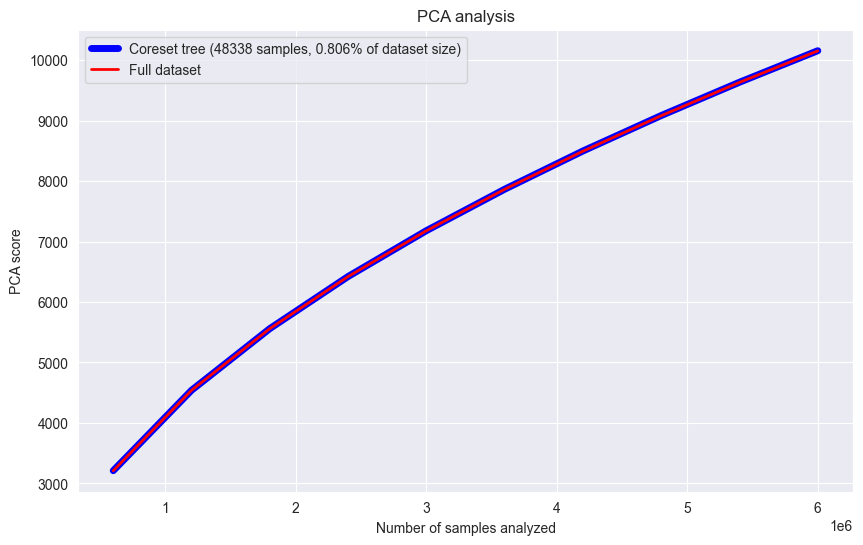

In [ ]:
fig_scores, axd_scores = plt.subplots(figsize=(10, 6))
axd_scores.plot(
    num_samples_per_iteration,
    coreset_scores,
    label=f"Coreset tree ({max(coreset_root_num_samples)} samples, {(max(coreset_root_num_samples) * 100 / x.shape[0]):.3f}% of dataset size)",
    color="blue",
    linewidth=5,
)
axd_scores.plot(num_samples_per_iteration, full_dataset_scores, label=f"Full dataset ", color="red", linewidth=2)
axd_scores.grid(True)
axd_scores.ticklabel_format(useOffset=False)
axd_scores.set_ylabel("PCA score")
axd_scores.set_xlabel("Number of samples analyzed")
axd_scores.legend()
_ = axd_scores.set_title("PCA analysis")

### 4.2 Visualize the timing for fitting the PCA model on the Coreset tree and on the full dataset
Plot the fit time for the full dataset PCA model and the build+fit time for the root Coreset PCA model.

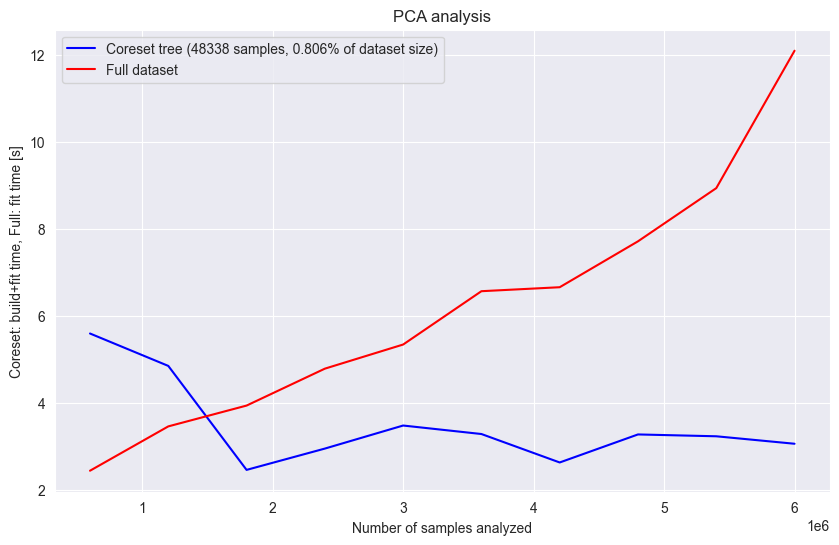

In [ ]:
fig_scores, axd_scores = plt.subplots(figsize=(10, 6))
axd_scores.plot(
    num_samples_per_iteration,
    coreset_times,
    label=f"Coreset tree ({max(coreset_root_num_samples)} samples, {(max(coreset_root_num_samples) * 100 / x.shape[0]):.3f}% of dataset size)",
    color="blue",
)
axd_scores.plot(num_samples_per_iteration, full_dataset_times, label=f"Full dataset ", color="red")
axd_scores.grid(True)
axd_scores.ticklabel_format(useOffset=False)
axd_scores.set_ylabel("Coreset: build+fit time, Full: fit time [s]")
axd_scores.set_xlabel("Number of samples analyzed")
axd_scores.legend()
_ = axd_scores.set_title("PCA analysis")

### 4.3 Graphical illustration of dimensionality reduction and visualization of the Principal Components

Reduce this random set to 2 components using the full dataset and the root Coreset PCA models of the last iteration.

In [13]:
# Transform the full dataset with respect to the two PCA models
full_dataset_reduced_dim_x = full_dataset_model.transform(x)
coreset_reduced_dim_x = coreset_model.transform(x)
# Transform the two Principal Components with respect to their corresponding PCA models
full_dataset_reduced_dim_origin = full_dataset_model.transform(np.zeros((n_components, x.shape[1])))
full_dataset_reduced_dim_pcs = full_dataset_model.transform(full_dataset_model.components_)
coreset_reduced_dim_origin = coreset_model.transform(np.zeros((n_components, x.shape[1])))
coreset_reduced_dim_pcs = coreset_model.transform(coreset_model.components_)
# Determine the coordinates of the two Principal Components for the full dataset
full_dataset_pcs = {}
for i, (origin, component, variance) in enumerate(
    zip(full_dataset_reduced_dim_origin, full_dataset_reduced_dim_pcs, full_dataset_model.explained_variance_)
):
    # Scale component by its variance explanation power
    component = component * variance
    full_dataset_pcs[i] = (component[0] - origin[0], -component[1] + origin[1])
# Determine the coordinates of the two Principal Components for the coreset
coreset_pcs = {}
for i, (origin, component, variance) in enumerate(
    zip(coreset_reduced_dim_origin, coreset_reduced_dim_pcs, coreset_model.explained_variance_)
):
    # Scale component by its variance explanation power
    component = component * variance
    coreset_pcs[i] = (component[0] - origin[0], -component[1] + origin[1])

Plot, side-by-side, the 2-dimensional points of the dataset set, transformed by the full dataset PCA model and by the root Coreset PCA model. Add on each plot the 2 Principal Components for each of the two PCA models.

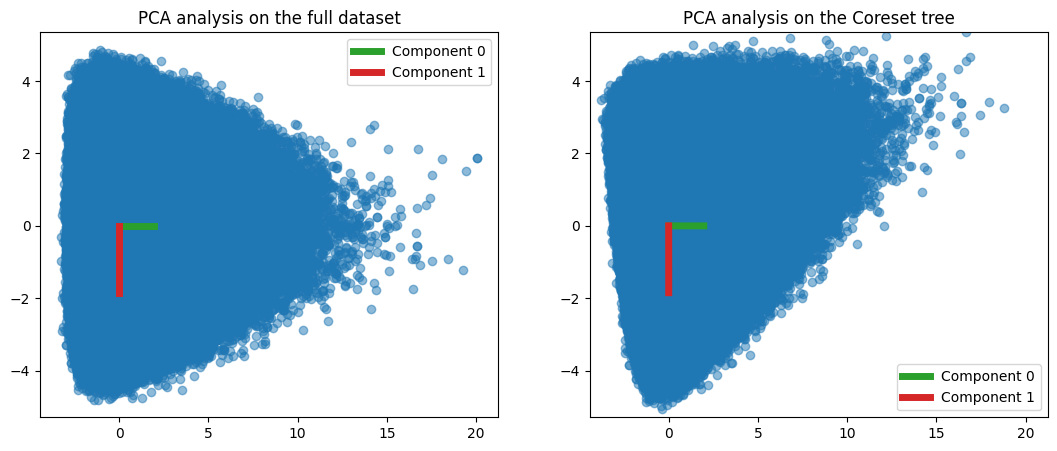

In [14]:
fig1, axs1 = plt.subplots(1, 2, figsize=(13, 5))

# Plot the random set transformed by the PCA model trained on the full dataset
axs1[0].set_title("PCA analysis on the full dataset")
axs1[0].scatter(full_dataset_reduced_dim_x[:, 0], full_dataset_reduced_dim_x[:, 1], alpha=0.5)
# Plot the Principal Components of the full dataset
for i, (origin, component, variance) in enumerate(
    zip(full_dataset_reduced_dim_origin, full_dataset_reduced_dim_pcs, full_dataset_model.explained_variance_)
):
    # Scale component by its variance explanation power
    component = component * variance
    axs1[0].plot(
        [0, component[0] - origin[0]],
        [0, -component[1] + origin[1]],
        label=f"Component {i}",
        linewidth=5,
        color=f"C{i + 2}",
    )
_ = axs1[0].legend()

# Plot the random set transformed by the PCA model trained on the root Coreset
axs1[1].set_title("PCA analysis on the Coreset tree")
axs1[1].scatter(coreset_reduced_dim_x[:, 0], coreset_reduced_dim_x[:, 1], alpha=0.5)
# Plot the Principal Components of the root Coreset
for i, (origin, component, variance) in enumerate(
    zip(coreset_reduced_dim_origin, coreset_reduced_dim_pcs, coreset_model.explained_variance_)
):
    # Scale component by its variance explanation power
    component = component * variance
    axs1[1].plot(
        [0, component[0] - origin[0]],
        [0, -component[1] + origin[1]],
        label=f"Component {i}",
        linewidth=5,
        color=f"C{i + 2}",
    )
_ = axs1[1].legend()
_ = axs1[1].set_xlim(axs1[0].get_xlim())
_ = axs1[1].set_ylim(axs1[0].get_ylim())

### 4.4 Compare the correlation matrix for the full dataset and for the root Coreset
Calculate the correlation matrix for the full dataset.

In [15]:
# Calculate the correlation matrix for the full dataset
full_dataset_correlation_matrix_start_time = time()
full_dataset_correlation_matrix = np.corrcoef(x.T)
full_dataset_correlation_matrix_time = time() - full_dataset_correlation_matrix_start_time
print(
    f"Calculation of the correlation matrix for the full dataset took {full_dataset_correlation_matrix_time:.3f} seconds"
)

Calculation of the correlation matrix for the full dataset took 0.420 seconds


Calculate the correlation matrix of the root Coreset.

In [16]:
# Get the root of the Coreset tree for accessing the samples in the root Coreset and their weights
coreset = service_obj.get_coreset()
coreset_x = coreset["X"]
coreset_weights = coreset["w"]


# Define a routine for calculating correlation coefficients when observation vectors have weights
def weighted_correlation_coefficients(m, weights):
    covmat = np.cov(m, aweights=weights)
    return covmat / np.sqrt(np.outer(np.diagonal(covmat), np.diagonal(covmat)))


# Calculate the correlation matrix for the root Coreset
coreset_correlation_matrix_start_time = time()
coreset_correlation_matrix = weighted_correlation_coefficients(coreset_x.T, weights=coreset_weights)
coreset_correlation_matrix_time = time() - coreset_correlation_matrix_start_time
print(f"Calculation of the correlation matrix for the root Coreset took {coreset_correlation_matrix_time:.3f} seconds")

Calculation of the correlation matrix for the root Coreset took 0.003 seconds


Compare the full dataset and root Coreset correlation matrices.

In [17]:
# Determine the Mean Squared Error between the full dataset's and the root Coreset's correlation matrices
print(
    f"The Mean Squared Error between the full dataset's and the Coreset's correlation matrices: {mean_squared_error(full_dataset_correlation_matrix, coreset_correlation_matrix)}"
)

The Mean Squared Error between the full dataset's and the Coreset's correlation matrices: 7.155323526113465e-05


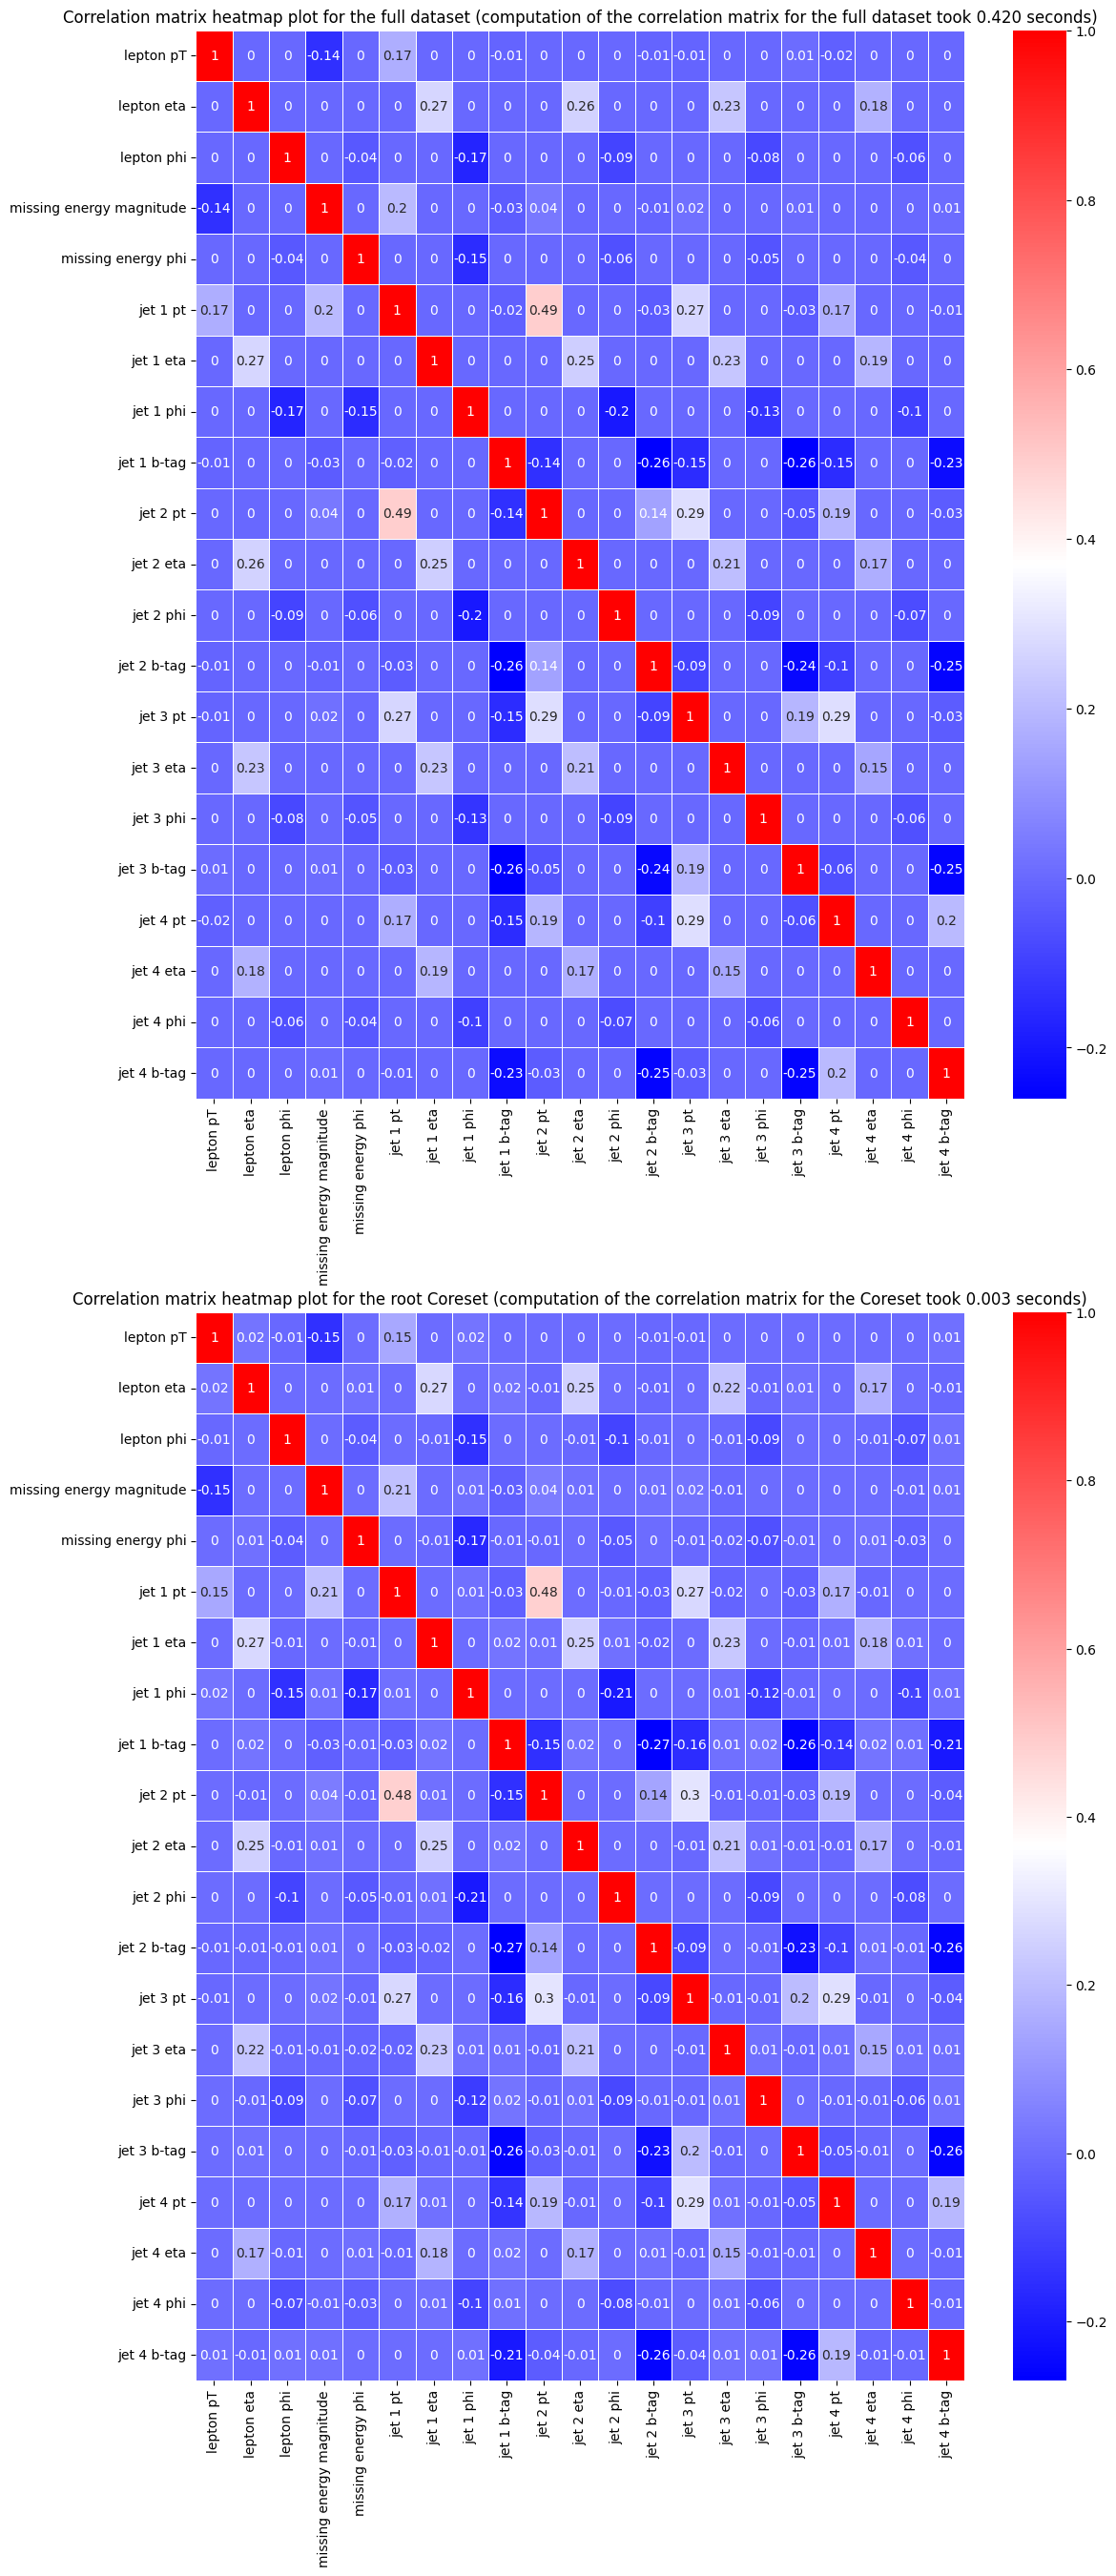

In [18]:
# Define the names of the dataset column (from dataset's webpage)
dataset_column_names = [
    "lepton pT",
    "lepton eta",
    "lepton phi",
    "missing energy magnitude",
    "missing energy phi",
    "jet 1 pt",
    "jet 1 eta",
    "jet 1 phi",
    "jet 1 b-tag",
    "jet 2 pt",
    "jet 2 eta",
    "jet 2 phi",
    "jet 2 b-tag",
    "jet 3 pt",
    "jet 3 eta",
    "jet 3 phi",
    "jet 3 b-tag",
    "jet 4 pt",
    "jet 4 eta",
    "jet 4 phi",
    "jet 4 b-tag",
]

# Plot the correlation matrix heatmaps
fig3, axs3 = plt.subplots(2, 1, figsize=(13, 32))
_ = axs3[0].set_title(
    f"Correlation matrix heatmap plot for the full dataset (computation of the correlation matrix for the full dataset took {full_dataset_correlation_matrix_time:.3f} seconds)"
)
_ = sns.heatmap(
    np.around(full_dataset_correlation_matrix, decimals=2) + 0.0,
    cmap="bwr",
    ax=axs3[0],
    yticklabels=dataset_column_names,
    xticklabels=dataset_column_names,
    annot=True,
    linewidths=0.5,
)
_ = axs3[1].set_title(
    f"Correlation matrix heatmap plot for the root Coreset (computation of the correlation matrix for the Coreset took {coreset_correlation_matrix_time:.3f} seconds)"
)
_ = sns.heatmap(
    np.around(coreset_correlation_matrix, decimals=2) + 0.0,
    cmap="bwr",
    ax=axs3[1],
    yticklabels=dataset_column_names,
    xticklabels=dataset_column_names,
    annot=True,
    linewidths=0.5,
)

### 4.5 Visualize scree plots for PCA models fitted on the full dataset and on the root Coreset

Considering a dimensionality reduction of the initial dataset to 15 components, fit PCA models on the full dataset and on the root Coreset and retrieve the explained variance percentages for each of PCAs' Principal Components.

In [19]:
n_components = 15

# Fit a PCA model on the root Coreset, taking into account the new number of components
coreset_model_2 = service_obj.fit(**{"n_components": n_components})
# Retrieve the explained variance percentages for the `n_components` Principal Components of the model
coreset_pc_explvarpct = coreset_model_2.explained_variance_ratio_

# Fit a PCA model on the full dataset
full_dataset_model_2 = PCA(n_components=n_components).fit(x)
# Retrieve the explained variance percentages for the `n_components` Principal Components of the model
full_dataset_pc_explvarpct = full_dataset_model_2.explained_variance_ratio_

Using WPCA model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMRegressor(**params), **other_params)


Construct and visualize the scree plots

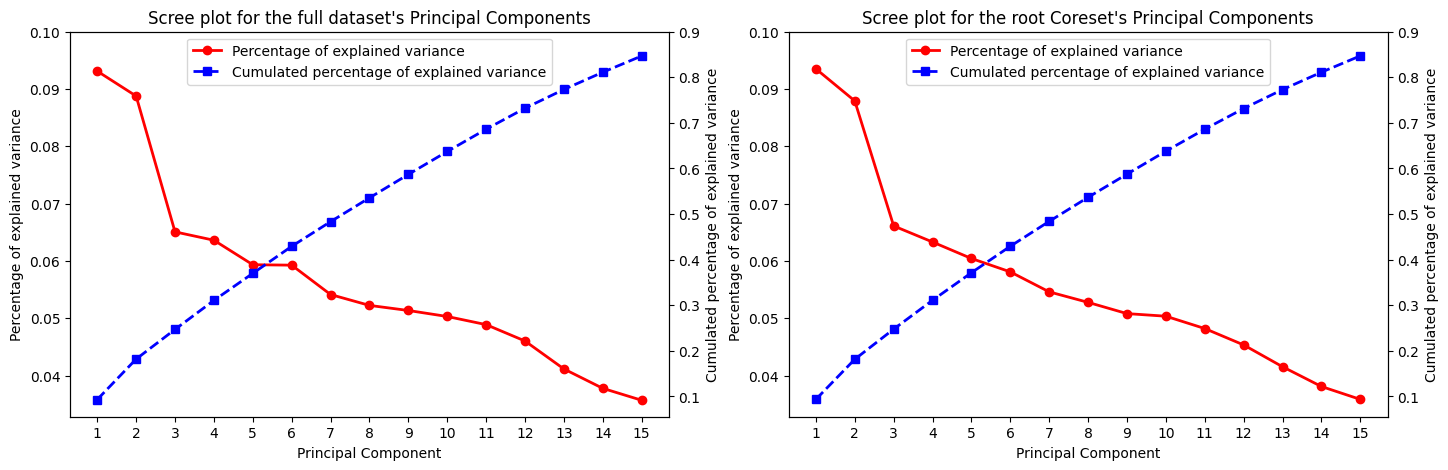

In [20]:
fig2, axs2 = plt.subplots(1, 2, figsize=(17, 5))

# Create mirrored Y axes
twin2 = [axs2[0].twinx(), axs2[1].twinx()]
# Indices of principal components, 1 indexed
pc_idxs = np.arange(len(full_dataset_pc_explvarpct)) + 1

# Construct the scree plot for the full dataset PCA model
axs2[0].set_title("Scree plot for the full dataset's Principal Components")
axs2[0].set_xlabel("Principal Component")
axs2[0].set_ylabel("Percentage of explained variance")
twin2[0].set_ylabel("Cumulated percentage of explained variance")
lines_1_1 = axs2[0].plot(
    pc_idxs, full_dataset_pc_explvarpct, "ro-", linewidth=2, label="Percentage of explained variance"
)
lines_1_2 = twin2[0].plot(
    pc_idxs,
    np.cumsum(full_dataset_pc_explvarpct),
    "bs--",
    linewidth=2,
    label="Cumulated percentage of explained variance",
)
lines_1 = lines_1_1 + lines_1_2
labels_1 = [l.get_label() for l in lines_1]
axs2[0].set_xticks(np.arange(1, 1 + len(full_dataset_pc_explvarpct), 1.0))
axs2[0].set_ylim(axs2[0].get_ylim()[0], 0.1)
twin2[0].set_ylim(twin2[0].get_ylim()[0], 0.9)
_ = axs2[0].legend(lines_1, labels_1, loc="upper center")

# Construct the scree plot for the root Coreset PCA model
axs2[1].set_title("Scree plot for the root Coreset's Principal Components")
axs2[1].set_xlabel("Principal Component")
axs2[1].set_ylabel("Percentage of explained variance")
twin2[1].set_ylabel("Cumulated percentage of explained variance")
lines_2_1 = axs2[1].plot(pc_idxs, coreset_pc_explvarpct, "ro-", linewidth=2, label="Percentage of explained variance")
lines_2_2 = twin2[1].plot(
    pc_idxs, np.cumsum(coreset_pc_explvarpct), "bs--", linewidth=2, label="Cumulated percentage of explained variance"
)
lines_2 = lines_2_1 + lines_2_2
labels_2 = [l.get_label() for l in lines_2]
axs2[1].set_xticks(np.arange(1, 1 + len(coreset_pc_explvarpct), 1.0))
axs2[1].set_ylim(axs2[0].get_ylim())
twin2[1].set_ylim(twin2[0].get_ylim())
_ = axs2[1].legend(lines_1, labels_1, loc="upper center")